In [1]:
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from model import Model, enc_dec_tensors
import numpy as np
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import tensorflow as tf

In [2]:
config_path = './config.npy'
metrics_path = './metrics.npy'
model_path = './models/model99.h5'
path_x = '../data/specs-x-match.npy'

In [3]:
config = np.load(config_path).item()
config

{'rate': 0.01,
 'train': True,
 'epochs': 100,
 'original_dim': 3794,
 'restore_epoch': 0,
 'latent_dim': 3,
 'batch_size': 32,
 'load_weights': False}

### Load Spectra from x-match & Filter

In [4]:
def filter_spectra(spec, labels):
    keep = [l in labels for l in spec['labels']]
    spec['labels'] = spec['labels'][keep]
    spec['flux'] = spec['flux'][keep]
    spec['names'] = spec['names'][keep]
    
    assert spec['labels'].shape[0]==spec['flux'].shape[0]
    assert spec['labels'].shape[0]==spec['names'].shape[0]
    
    return spec

In [5]:
labels = ['EA', 'EW', 'RRab', 'RRc', 'RS CVn']
spec = np.load(path_x).item()
spec = filter_spectra(spec, labels)
spec['flux'].shape

(3028, 3794)

### Encoding mean & decoding mean

In [6]:
def get_enc_dec(x, config, model_path):
    batch_size = x.shape[0]
    original_dim = config['original_dim']
    latent_dim = config['latent_dim']
    rate = config['rate']

    tf.reset_default_graph()
    with tf.Session() as sess:
        inputs, eps, _, _, _, _, _, _, _ = Model(batch_size, original_dim, latent_dim, rate)
        enc_mean, dec_mean = enc_dec_tensors()

        saver = tf.train.Saver()
        saver.restore(sess, model_path)

        eps_in = np.full([x.shape[0], latent_dim], 0)
        feed_dict = {inputs: x, eps: eps_in}
        enc_x, dec_x = sess.run([enc_mean, dec_mean],feed_dict=feed_dict)
        
    return enc_x, dec_x

In [7]:
x = spec['flux']
enc_x, dec_x = get_enc_dec(x, config, model_path)

[3794, 2846, 1898, 950, 3]
INFO:tensorflow:Restoring parameters from ./models/model99.h5


### R2

In [8]:
r2_score(x, dec_x)

0.9566487576293403

### Plot

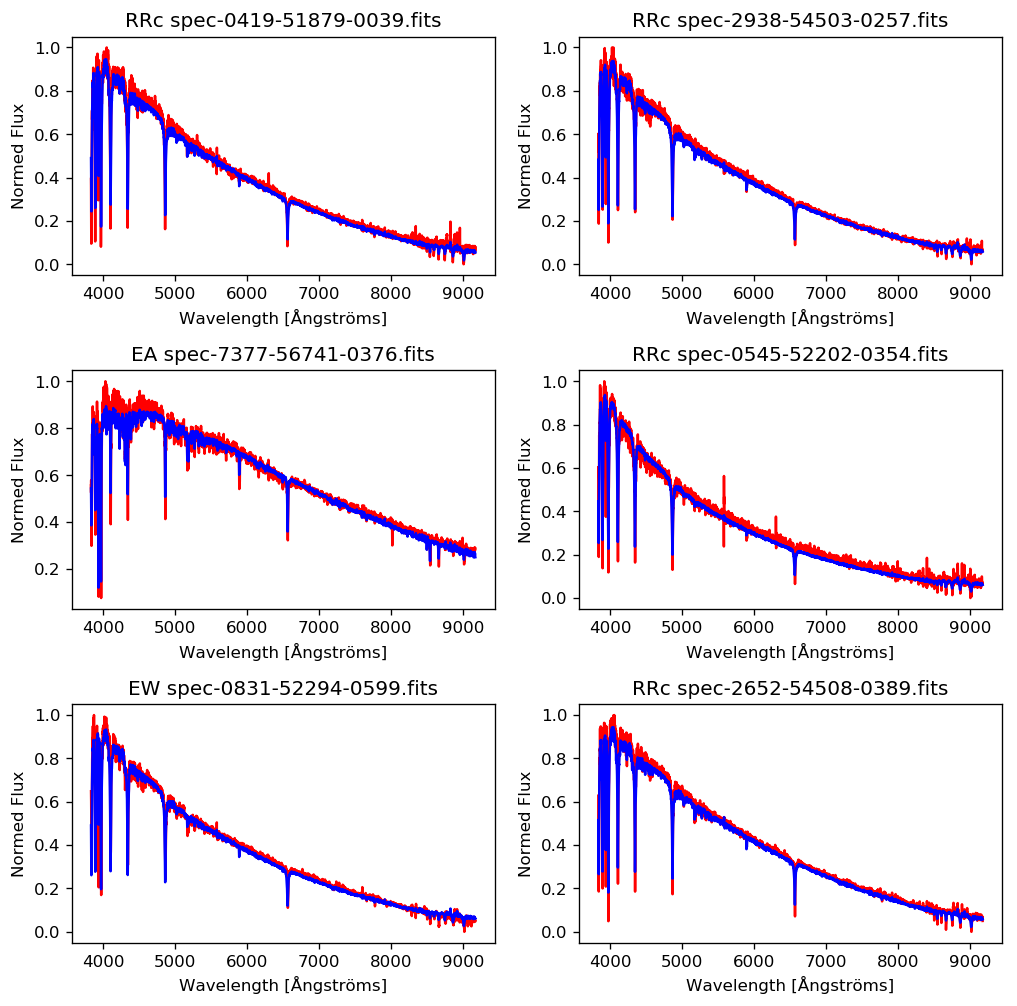

In [9]:
plt.figure(figsize=(10,10), dpi=120)
plt.subplots_adjust(hspace=0.4)
n = 6
samples = np.random.randint(0, x.shape[0], n)
w = spec['wlen_same']
for i in range(n):
    s = samples[i]
    plt.subplot(3,2,i+1)
    plt.plot(w, x[s], c='r')
    plt.plot(w, dec_x[s], c='b')
    plt.ylabel('Normed Flux')
    plt.xlabel('Wavelength [Ångströms]')
    plt.title(spec['labels'][s]+' '+spec['names'][s])
plt.show()

In [10]:
def get_z_vis(z, z_labels, method="pca", n_components=3):

    if method == "pca":
        z_vis = PCA(n_components=n_components).fit_transform(z)
    elif method == "tSNE":
        z_vis = TSNE(n_components=n_components).fit_transform(z)
        
    labels = np.unique(z_labels)
    colors = cm.tab20.colors
    to_colors = dict(zip(labels, colors))
    z_colors = list(map(lambda l: to_colors[l], z_labels))
    patches = [mpatches.Patch(color=c, label=l) for (l,c) in to_colors.items()]
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_vis[:,0], z_vis[:,1], z_vis[:,2], c=z_colors)
    plt.legend(handles=patches)
    plt.show()

<IPython.core.display.Javascript object>


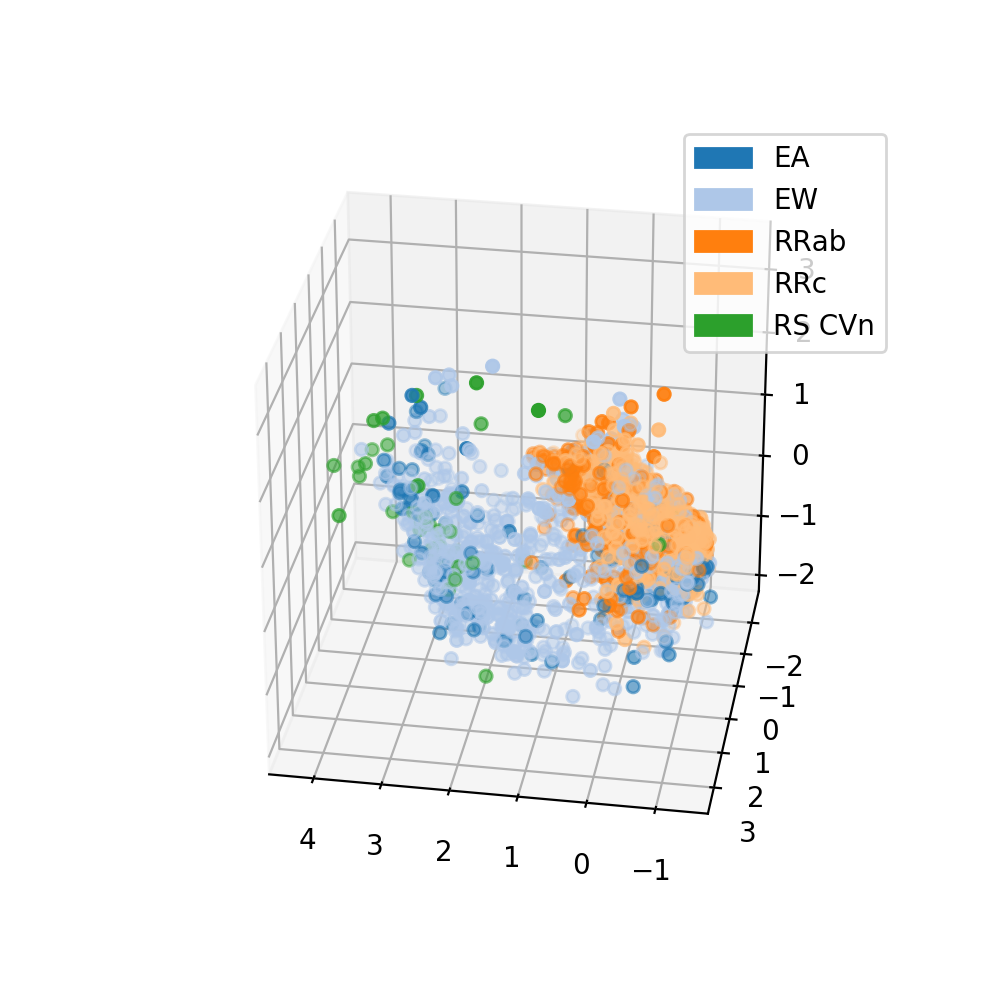

In [12]:
%matplotlib notebook
get_z_vis(enc_x, spec['labels'])

### Metrics

In [12]:
metrics = np.load(metrics_path).item()
metrics.keys()

dict_keys(['kl_train', 'rec_train', 'rec_val', 'loss_train', 'beta', 'kl_val', 'loss_val'])

[]

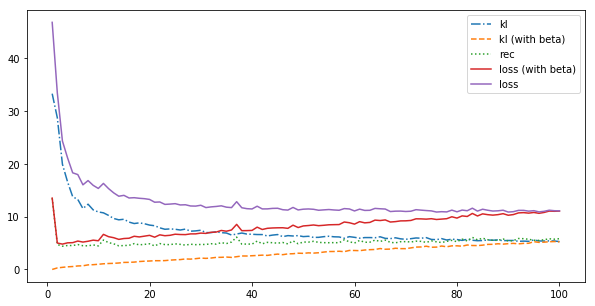

In [13]:
beta = metrics['beta']
kl = metrics['kl_val']
kl_beta = kl*beta
rec = metrics['rec_val']
loss_beta = metrics['loss_val']
loss = kl+rec
idx = list(range(1, len(kl)+1))
plt.figure(figsize=(10,5))
plt.plot(idx, kl, linestyle='-.', label='kl')
plt.plot(idx, kl_beta, linestyle='--', label='kl (with beta)')
plt.plot(idx, rec, linestyle=':', label='rec')
plt.plot(idx, loss_beta, linestyle='-', label='loss (with beta)')
plt.plot(idx, loss, linestyle='-', label='loss')
plt.legend()
plt.plot()